In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

from pathlib import Path
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split         # Split data into train and test set

from utils import evaluate_classifier, get_sklearn_df 

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Spring barley',
    'Vinterbyg': 'Winter barley',
    'Vårhvede': 'Spring wheat',
    'Vinterhvede': 'Winter wheat',
    'Vinterrug': 'Winter rye',
    'Vårhavre': 'Spring oat',
    'Silomajs': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Permanent græs, normalt udbytte': 'Permanent grass',
    'Græs uden kløvergræs (omdrift)': 'Grass silage',
    'Skovdrift, alm.': 'Forest'
}

# Set seed for random generators
RANDOM_SEED = 42

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [2]:
netcdf_path = (PROJ_PATH / 'data' / 'processed' / 'FieldPolygons2019_stats').with_suffix('.nc')
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 56751, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 67365067 67365062
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 205 ms


In [3]:
ds.close()

time: 21.3 ms


In [4]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns=['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 11.5 s


--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-08-01
Training time: 6.1344 s
Prediction time: 0.0615 s

Report:

Train accuracy: 0.289
Test accuracy: 0.3003


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-09-01
Training time: 9.3082 s
Prediction time: 0.0037 s

Report:

Train accuracy: 0.3471
Test accuracy: 0.3352
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-10-01
Training time: 12.3418 s
Prediction time: 0.0044 s

Report:

Train accuracy: 0.4338
Test accuracy: 0.4264
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-11-01
Training time: 15.9682 s
Prediction time: 0.0054 s

Report:

Train accuracy: 0.4873
Test accuracy: 0.4788
--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-12-01
Training time: 18.6863 s
Prediction time: 0.0052 s

Report:

Train accuracy: 0.5104
Test accuracy: 0.501
------------------------------

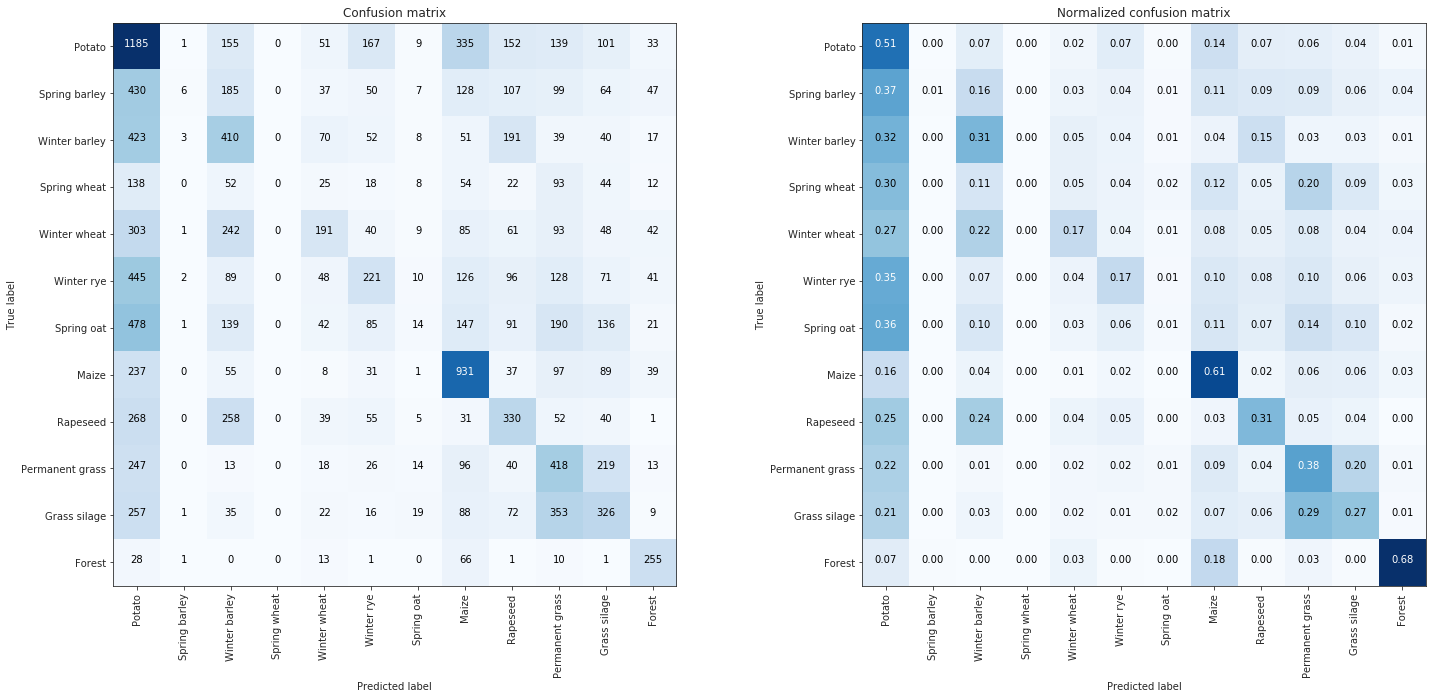

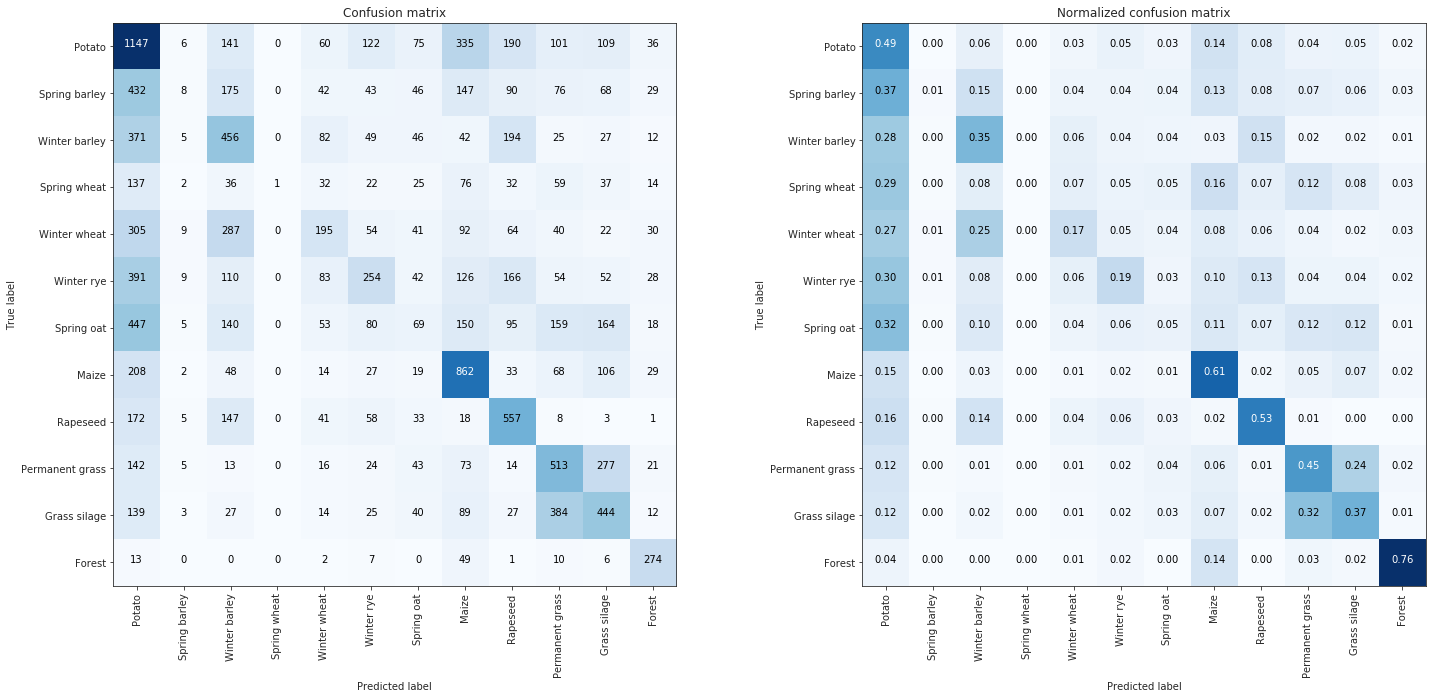

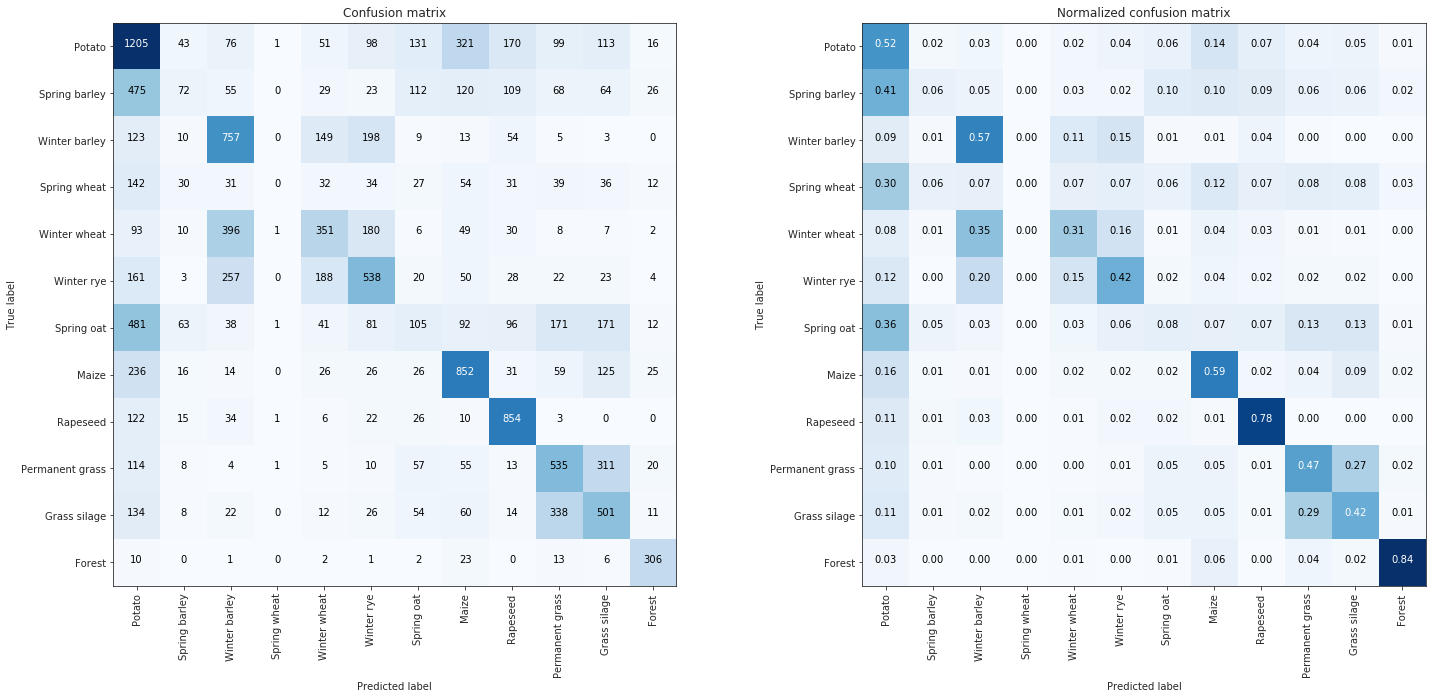

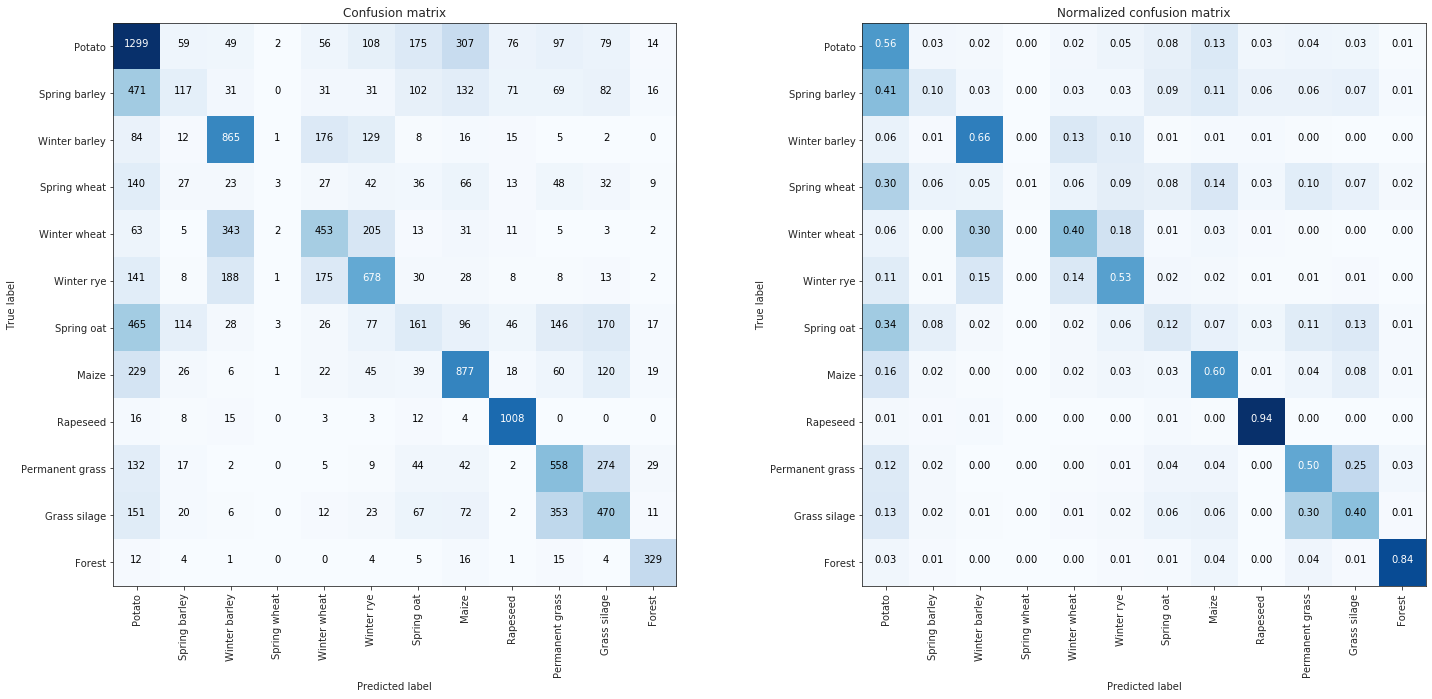

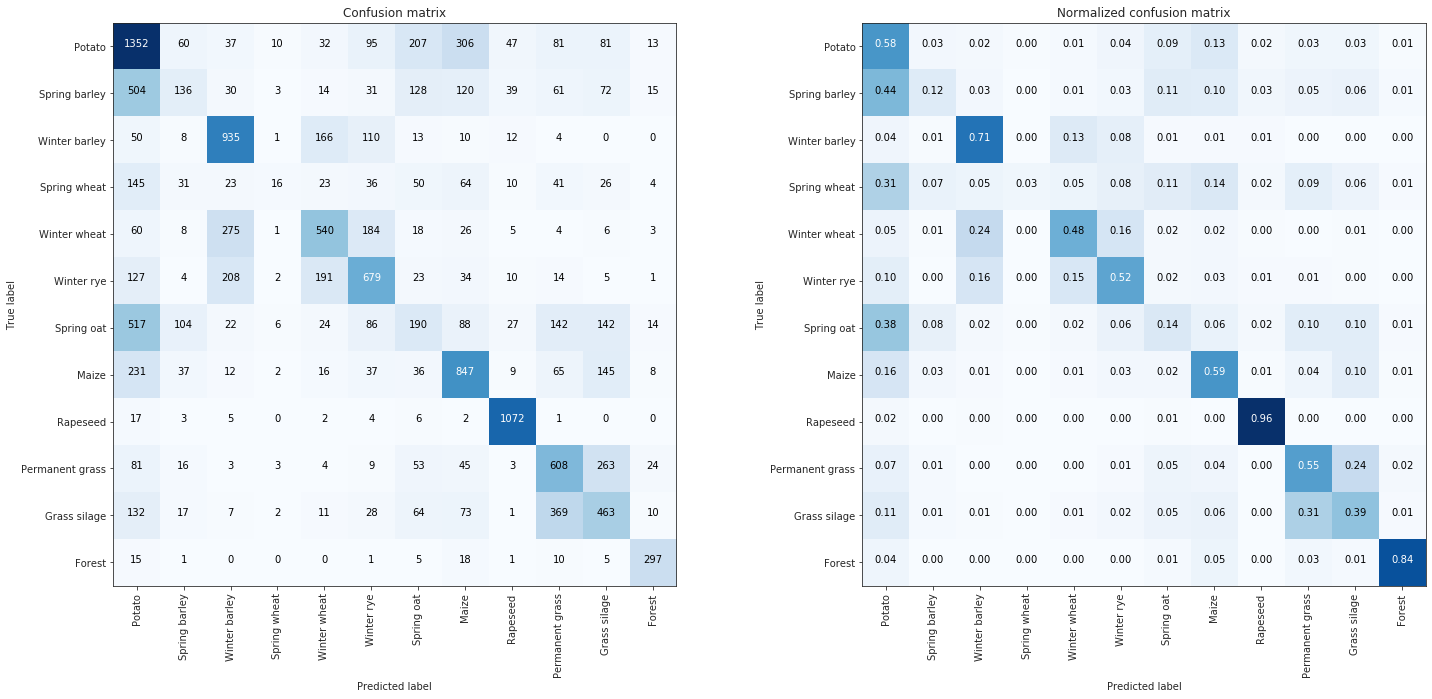

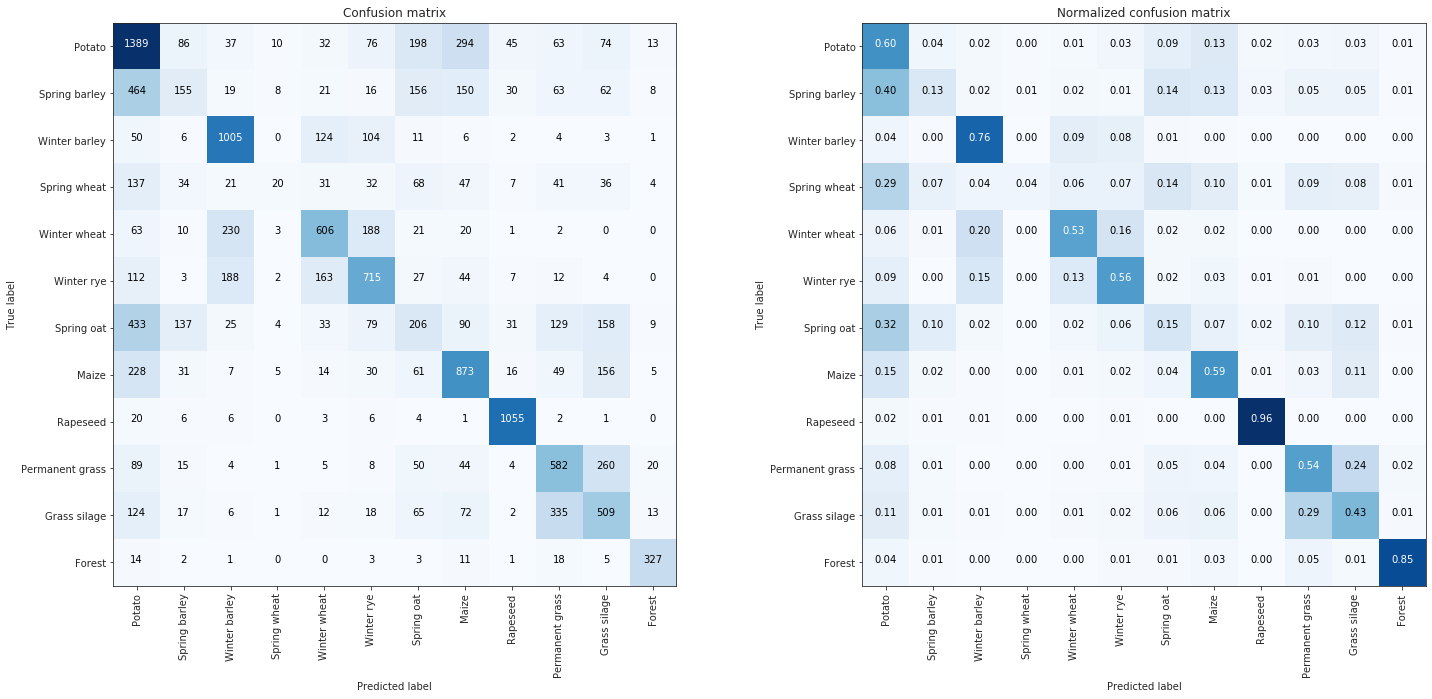

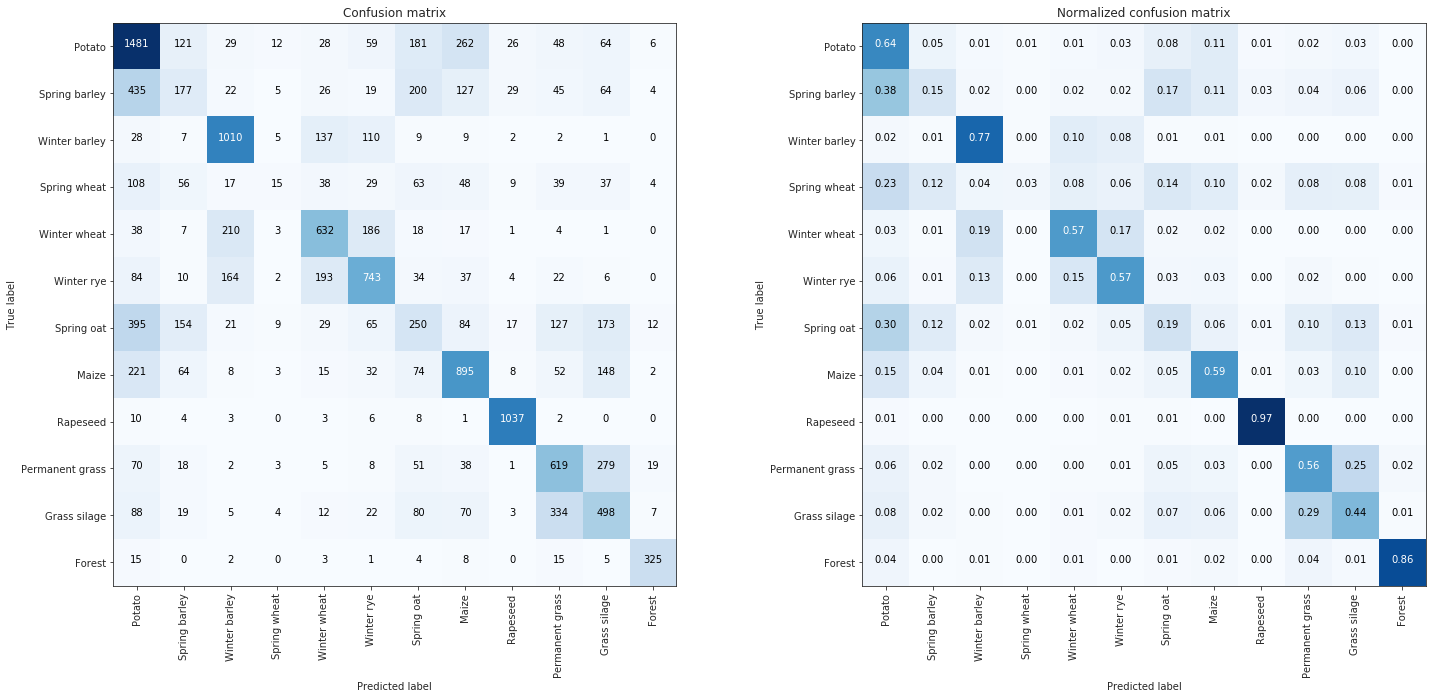

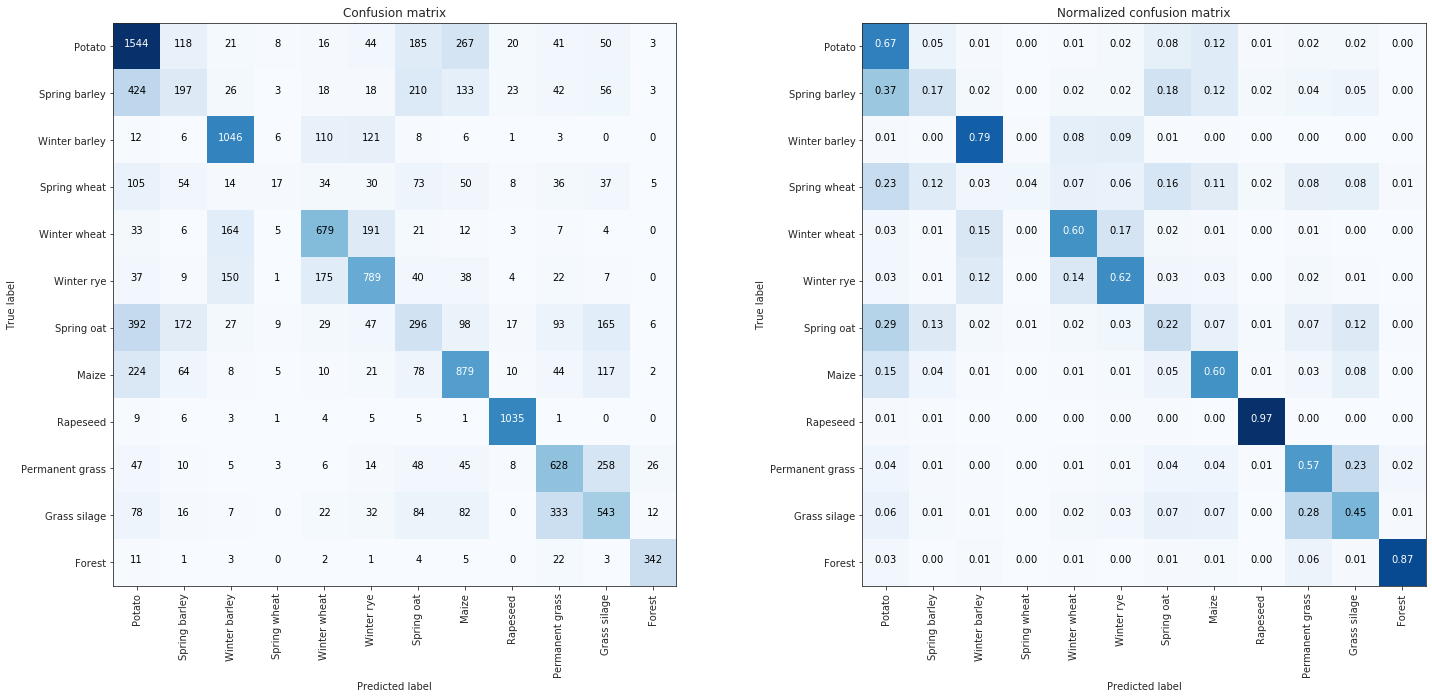

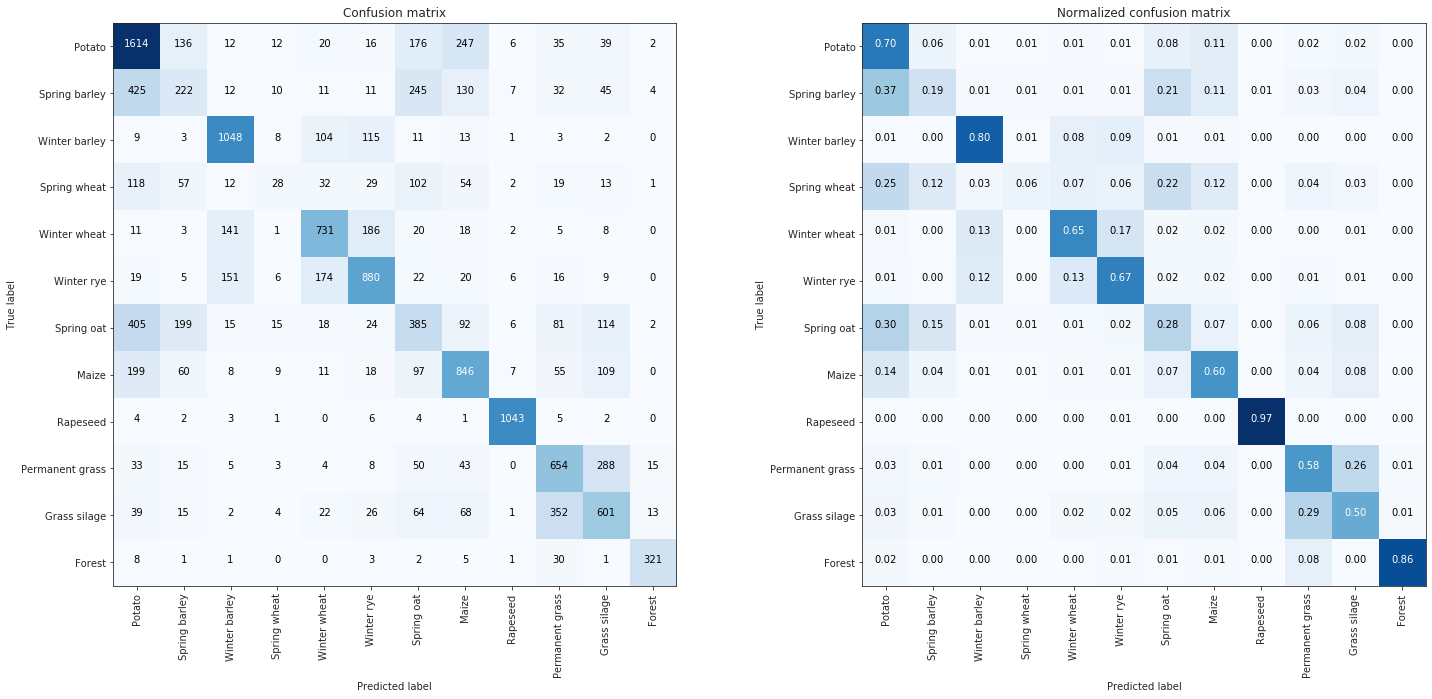

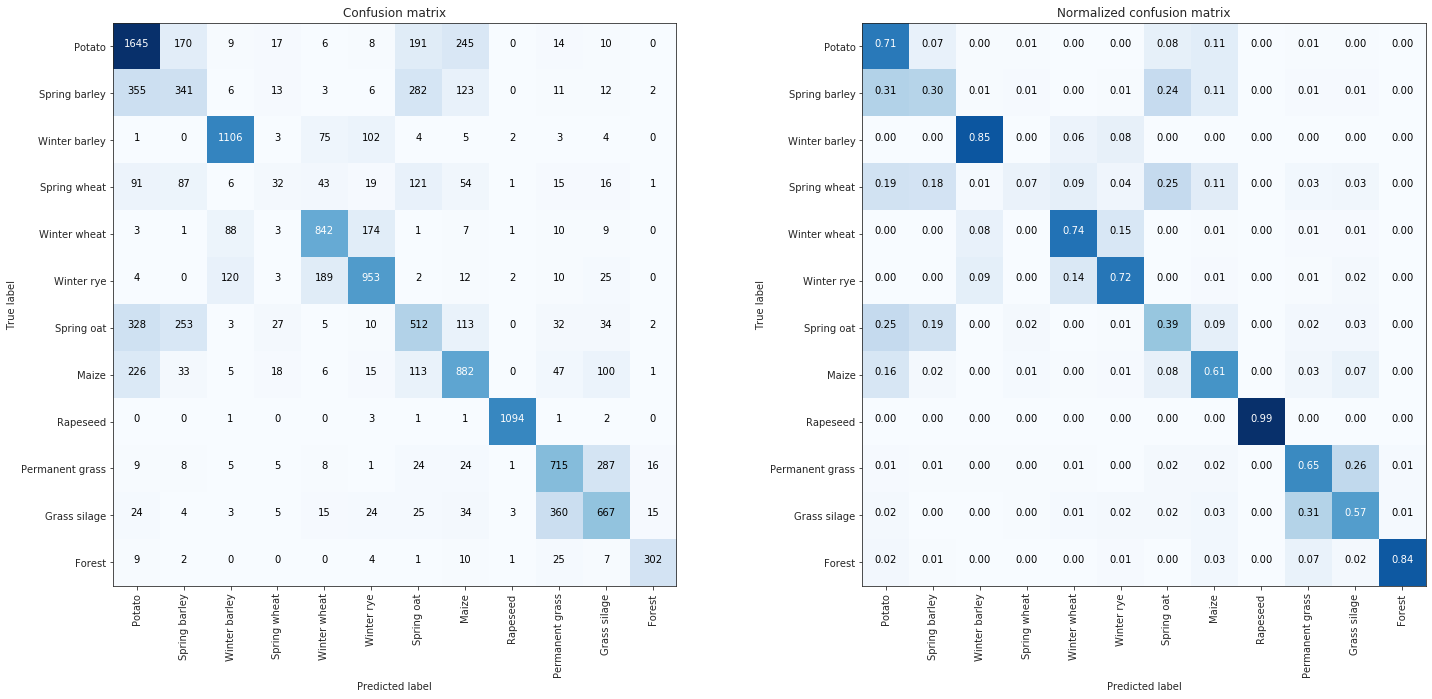

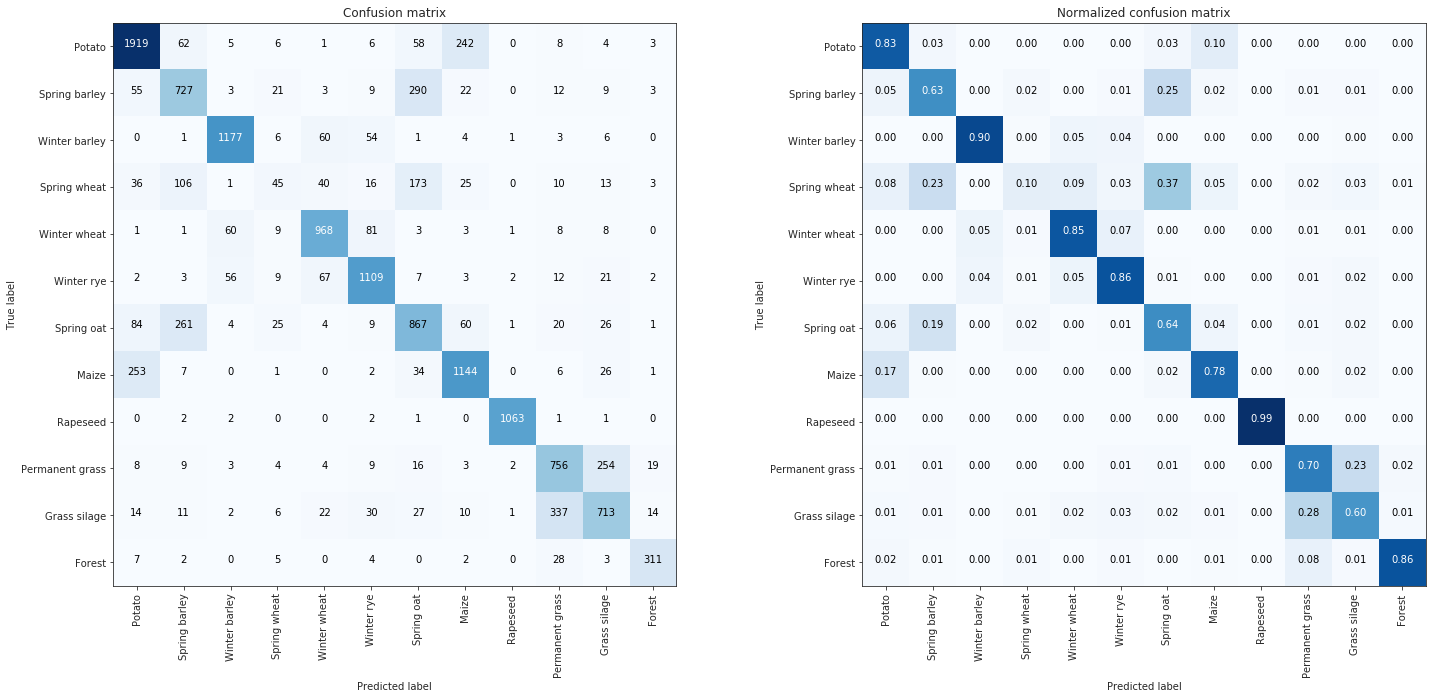

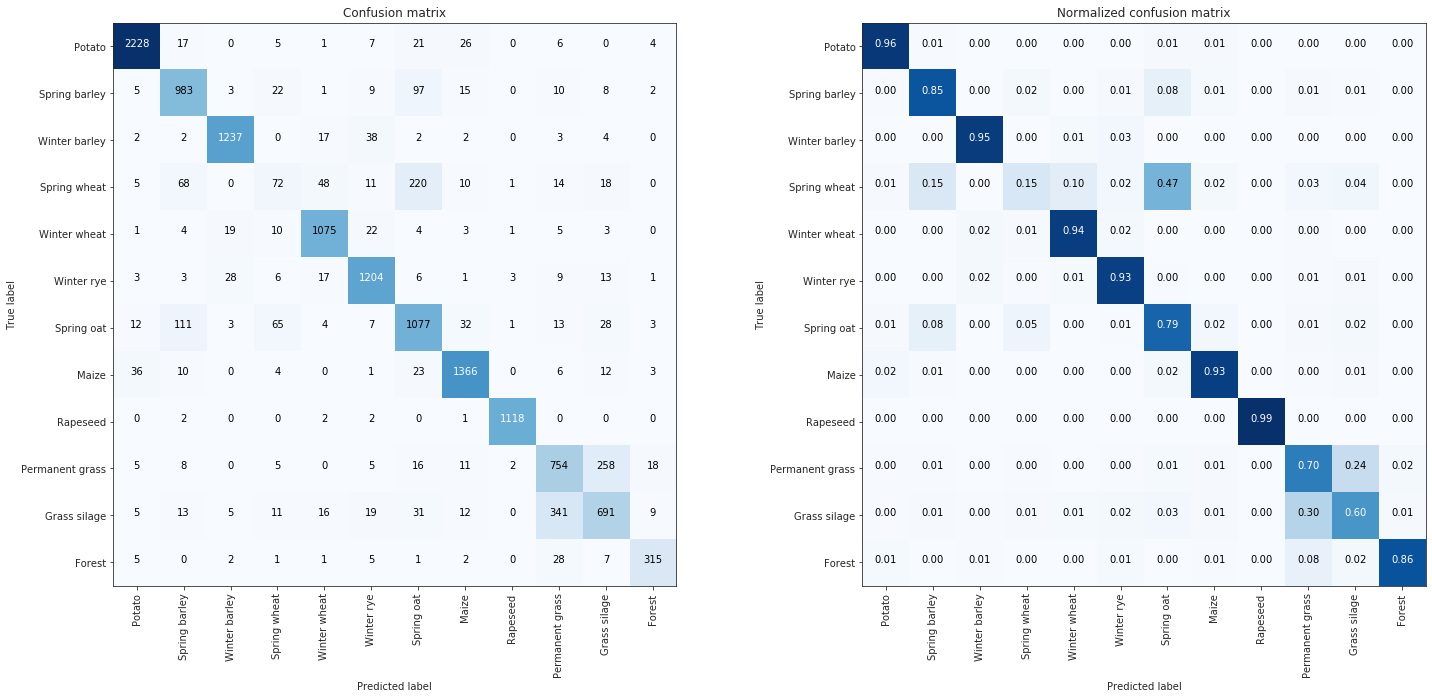

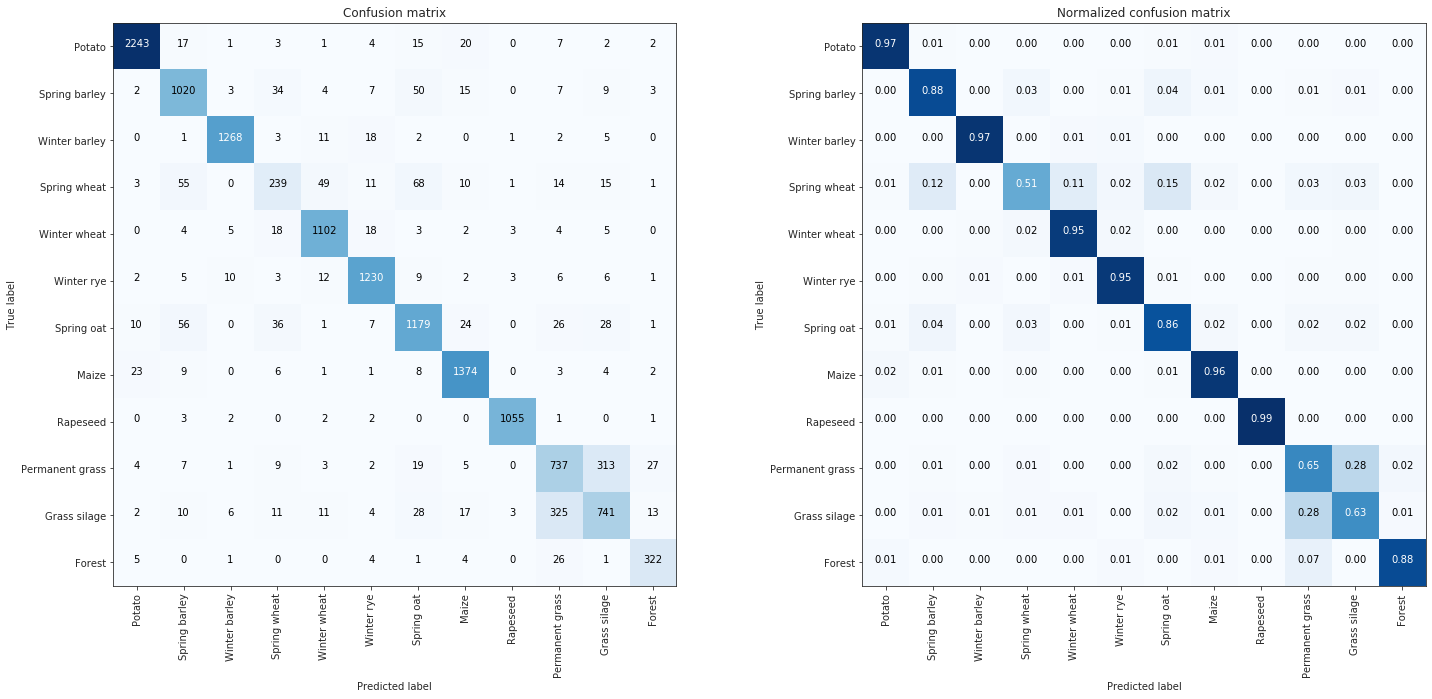

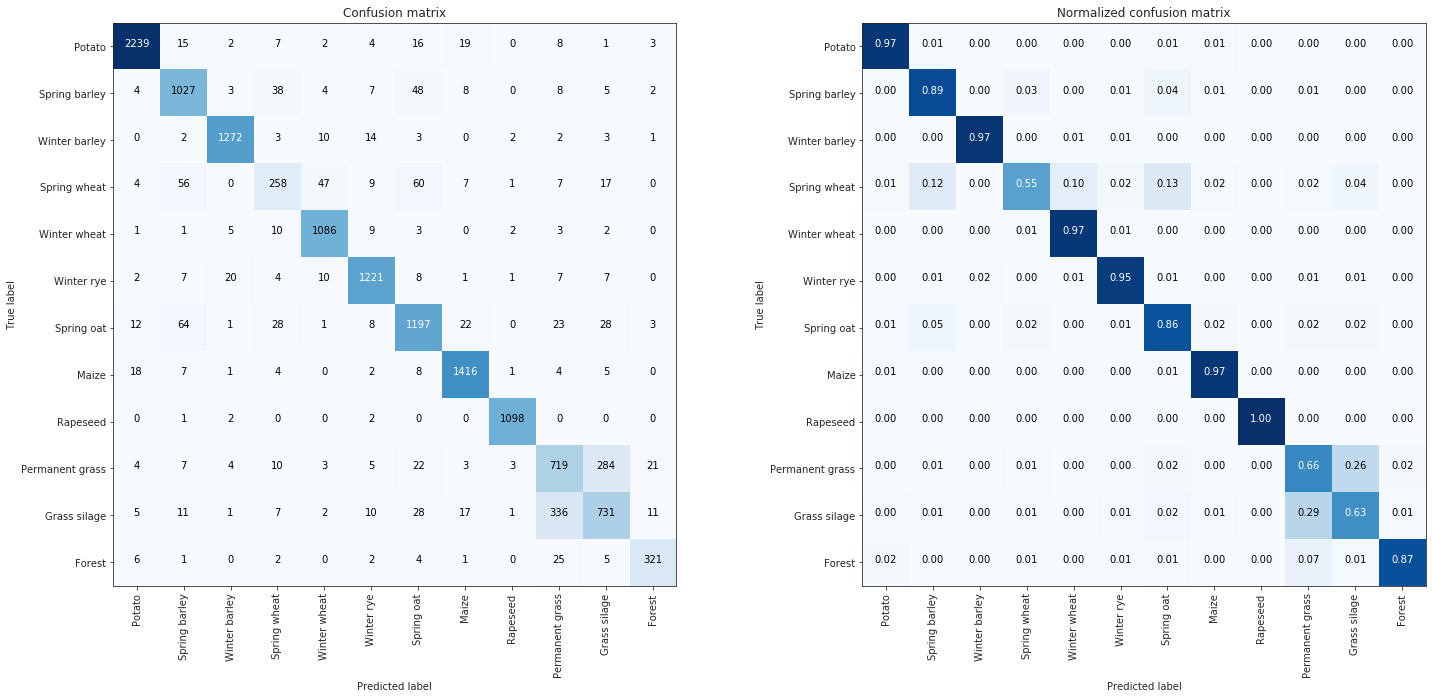

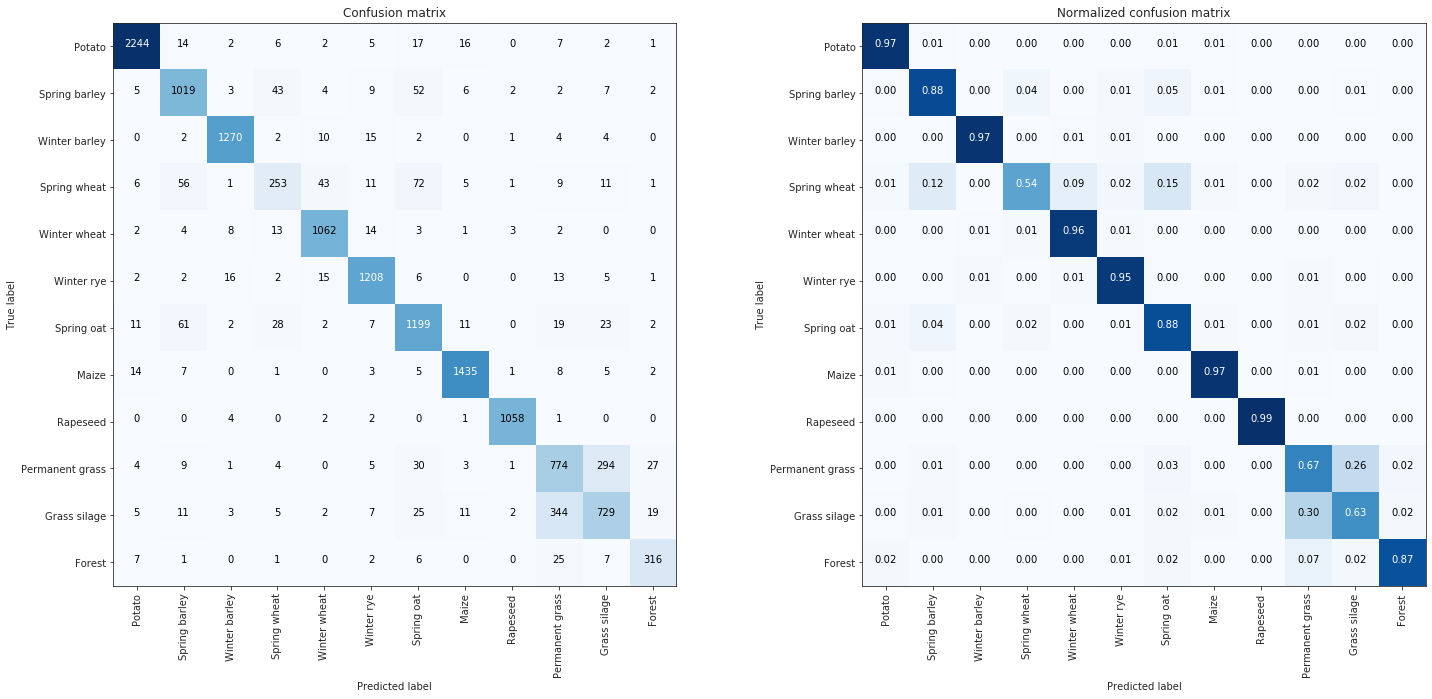

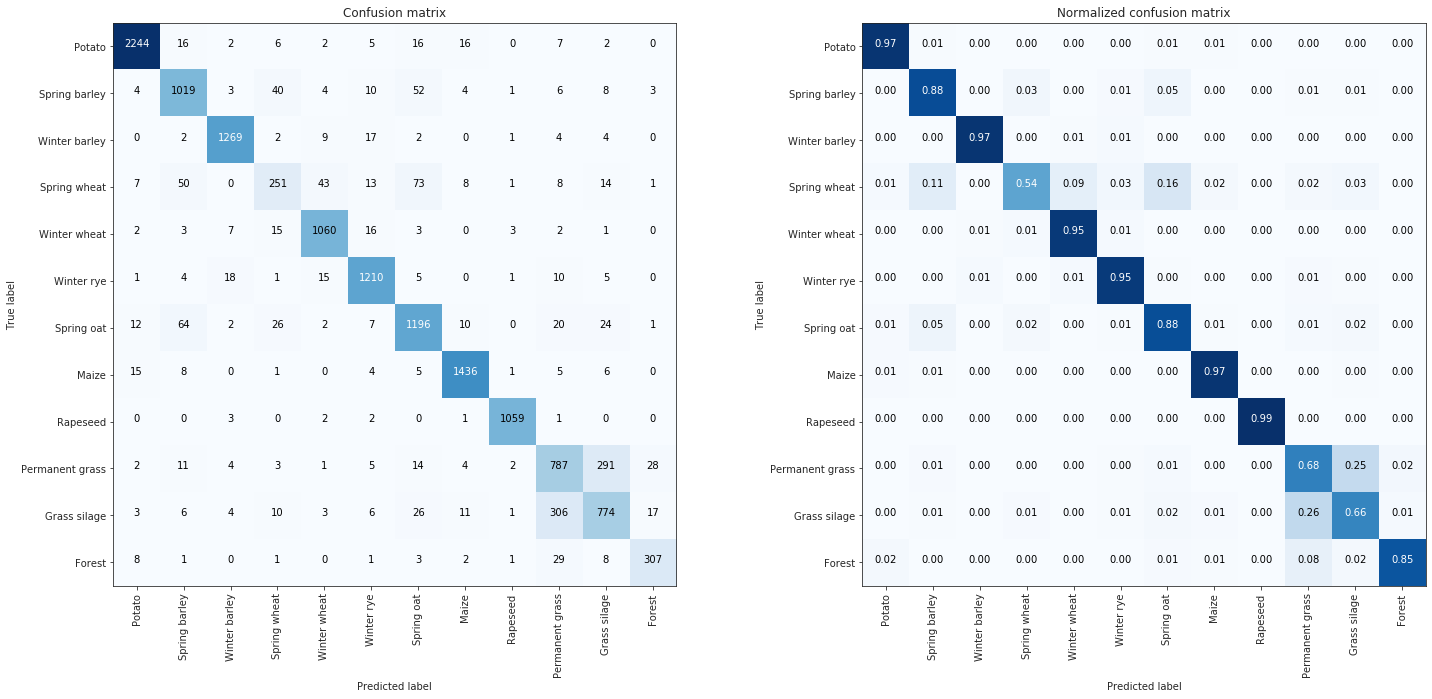

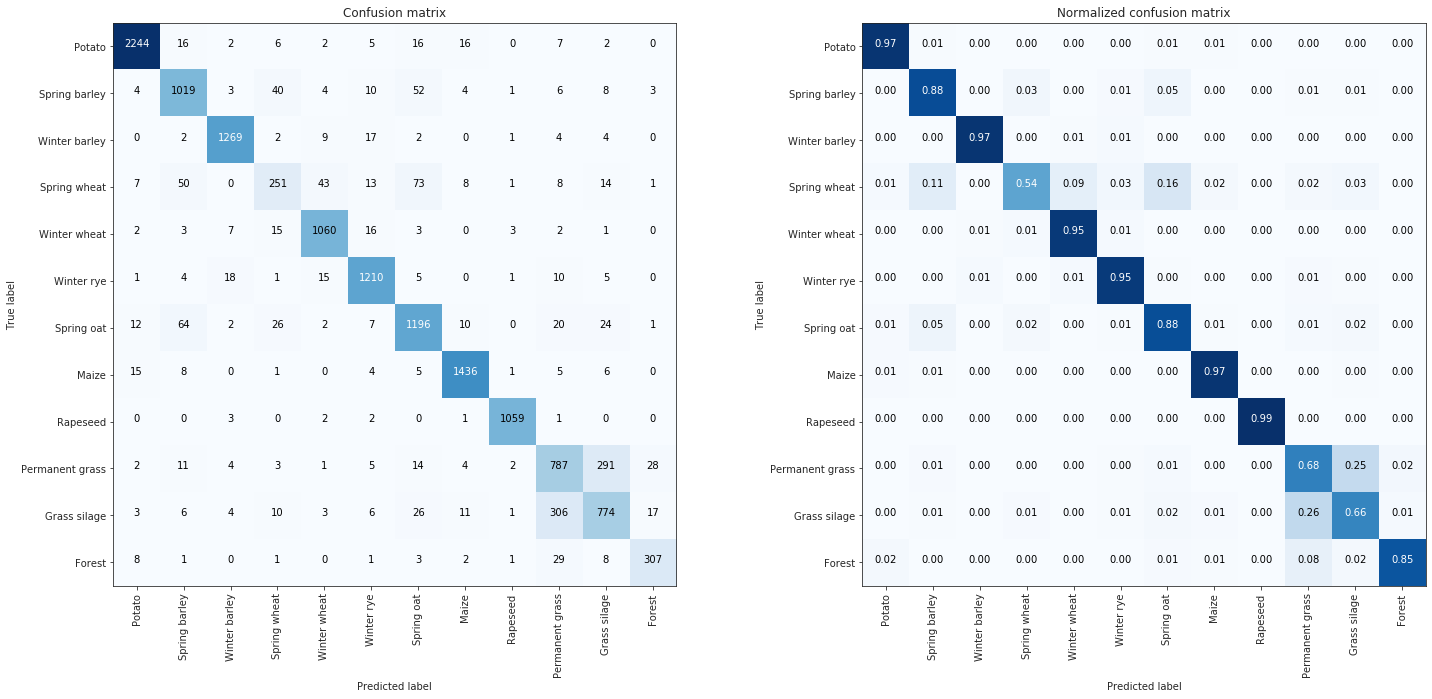

time: 14min 21s


In [5]:
# Dicts to hold results
test_acc_logistic_regression = {'2018-07-01': 0}
classification_reports_logistic_regression = {}
trained_classifiers_logistic_regression = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.linear_model import LogisticRegression          
    clf = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=32, max_iter=1000)
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_conf_matrix=True,
                                                                        print_classification_report=False)
    
    test_acc_logistic_regression[end_date] = accuracy_test
    classification_reports_logistic_regression[end_date] = results_report 
    trained_classifiers_logistic_regression[end_date] = clf_trained 

[autoreload of sklearn.utils failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: safe_indexing() requires a code object with 2 free vars, not 0
]
[autoreload of sklearn.utils.extmath failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.7/site-packages/IPython

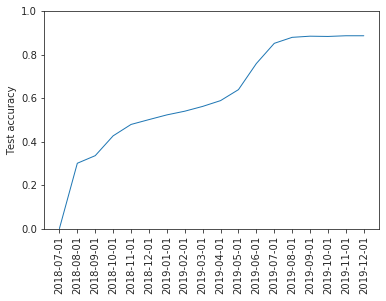

time: 2.67 s


In [6]:
x = list(test_acc_logistic_regression.keys())
y = list(test_acc_logistic_regression.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [7]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

time: 19.3 ms


In [8]:
# Dicts to hold results
test_acc_logistic_regression_balanced = {'2018-07-01': 0}
classification_reports_logistic_regression_balanced = {}
trained_classifiers_logistic_regression_balanced = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.linear_model import LogisticRegression          
    clf = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=32, max_iter=1000, class_weight='balanced')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_conf_matrix=True,
                                                                        print_classification_report=False)
    
    test_acc_logistic_regression_balanced[end_date] = accuracy_test
    classification_reports_logistic_regression_balanced[end_date] = results_report 
    trained_classifiers_logistic_regression_balanced[end_date] = clf_trained 

--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-08-01


TypeError: check_is_fitted() missing 1 required positional argument: 'attributes'

time: 1.97 s


In [ ]:
x = list(test_acc_logistic_regression_balanced.keys())
y = list(test_acc_logistic_regression_balanced.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [ ]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

In [ ]:
# Dicts to hold results
test_acc_logistic_regression_cv = {'2018-07-01': 0}
classification_reports_logistic_regression_cv = {}
trained_classifiers_logistic_regression_cv = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.linear_model import LogisticRegressionCV          

    # Instantiate and evaluate classifier
    clf = LogisticRegressionCV(solver='lbfgs', multi_class='auto', cv=5, n_jobs=32, random_state=RANDOM_SEED, max_iter=1000)
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_conf_matrix=True,
                                                                        print_classification_report=False)
    
    test_acc_logistic_regression_cv[end_date] = accuracy_test
    classification_reports_logistic_regression_cv[end_date] = results_report 
    trained_classifiers_logistic_regression_cv[end_date] = clf_trained 
    

In [ ]:
x = list(test_acc_logistic_regression_cv.keys())
y = list(test_acc_logistic_regression_cv.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [ ]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

In [ ]:
# Dicts to hold results
test_acc_logistic_regression_cv_balanced = {'2018-07-01': 0}
classification_reports_logistic_regression_cv_balanced = {}
trained_classifiers_logistic_regression_cv_balanced = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.linear_model import LogisticRegressionCV          

    # Instantiate and evaluate classifier
    clf = LogisticRegressionCV(solver='lbfgs', multi_class='auto', cv=5, n_jobs=32, random_state=RANDOM_SEED, max_iter=1000, 
                               class_weight='balanced')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_conf_matrix=True,
                                                                        print_classification_report=False)
    
    test_acc_logistic_regression_cv_balanced[end_date] = accuracy_test
    classification_reports_logistic_regression_cv_balanced[end_date] = results_report 
    trained_classifiers_logistic_regression_cv_balanced[end_date] = clf_trained 

In [ ]:
x = list(test_acc_logistic_regression_cv_balanced.keys())
y = list(test_acc_logistic_regression_cv_balanced.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [ ]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

In [ ]:
# Dicts to hold results
test_acc_svm_linear = {'2018-07-01': 0}
classification_reports_svm_linear = {}
trained_classifiers_svm_linear = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.svm import SVC   
    from sklearn.model_selection import GridSearchCV

    # Instantiate and evaluate classifier
    param_grid = {'C': [1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear']}
    #clf = GridSearchCV(SVC(), param_grid, refit=True, cv=5, verbose=0, n_jobs=32)
    clf = SVC(kernel='linear')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_conf_matrix=True,
                                                                        print_classification_report=False)
    
    test_acc_svm_linear[end_date] = accuracy_test
    classification_reports_svm_linear[end_date] = results_report 
    trained_classifiers_svm_linear[end_date] = clf_trained 

In [ ]:
x = list(test_acc_svm_linear.keys())
y = list(test_acc_svm_linear.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [ ]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

In [ ]:
# Dicts to hold results
test_acc_svm_linear_balanced = {'2018-07-01': 0}
classification_reports_svm_linear_balanced = {}
trained_classifiers_svm_linear_balanced = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.svm import SVC   
    from sklearn.model_selection import GridSearchCV

    # Instantiate and evaluate classifier
    param_grid = {'C': [1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear']}
    #clf = GridSearchCV(SVC(class_weight='balanced'), param_grid, refit=True, cv=5, verbose=0, n_jobs=32)
    clf = SVC(kernel='linear', class_weight='balanced')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_conf_matrix=True,
                                                                        print_classification_report=False)
    
    test_acc_svm_linear_balanced[end_date] = accuracy_test
    classification_reports_svm_linear_balanced[end_date] = results_report 
    trained_classifiers_svm_linear_balanced[end_date] = clf_trained 

In [ ]:
x = list(test_acc_svm_linear_balanced.keys())
y = list(test_acc_svm_linear_balanced.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [ ]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

In [ ]:
# Dicts to hold results
test_acc_svm_rbf = {'2018-07-01': 0}
classification_reports_svm_rbf = {}
trained_classifiers_svm_rbf = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.svm import SVC   
    from sklearn.model_selection import GridSearchCV

    # Instantiate and evaluate classifier
    param_grid = {'C': [1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['rbf']}
    #clf = GridSearchCV(SVC(), param_grid, refit=True, cv=5, verbose=0, n_jobs=32)
    clf = SVC(kernel='rbf')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_conf_matrix=True,
                                                                        print_classification_report=False)
    
    test_acc_svm_rbf[end_date] = accuracy_test
    classification_reports_svm_rbf[end_date] = results_report 
    trained_classifiers_svm_rbf[end_date] = clf_trained 

In [ ]:
x = list(test_acc_svm_rbf.keys())
y = list(test_acc_svm_rbf.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [ ]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

In [ ]:
# Dicts to hold results
test_acc_svm_rbf_balanced = {'2018-07-01': 0}
classification_reports_svm_rbf_balanced = {}
trained_classifiers_svm_rbf_balanced = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.svm import SVC   
    from sklearn.model_selection import GridSearchCV

    # Instantiate and evaluate classifier
    param_grid = {'C': [1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['rbf']}
    #clf = GridSearchCV(SVC(class_weight='balanced'), param_grid, refit=True, cv=5, verbose=0, n_jobs=32)
    clf = SVC(kernel='rbf', class_weight='balanced')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_conf_matrix=True,
                                                                        print_classification_report=False)
    
    test_acc_svm_rbf_balanced[end_date] = accuracy_test
    classification_reports_svm_rbf_balanced[end_date] = results_report 
    trained_classifiers_svm_rbf_balanced[end_date] = clf_trained 

In [ ]:
x = list(test_acc_svm_rbf_balanced.keys())
y = list(test_acc_svm_rbf_balanced.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [ ]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

In [ ]:
# Dicts to hold results
test_acc_svm_rbf_cv = {'2018-07-01': 0}
classification_reports_svm_rbf_cv = {}
trained_classifiers_svm_rbf_cv = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.svm import SVC   
    from sklearn.model_selection import GridSearchCV

    param_grid = {'C': [1, 3, 5, 10, 30, 50, 100, 300, 500, 1000], 'kernel': ['rbf']}
    clf = GridSearchCV(SVC(), param_grid, refit=True, cv=5, verbose=0, n_jobs=12)
    #clf = SVC(kernel='rbf')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_conf_matrix=True,
                                                                        print_classification_report=False)
    
    print(f"The best parameters are {clf_trained.best_params_} with a score of {clf_trained.best_score_:2f}")
    
    test_acc_svm_rbf_cv[end_date] = accuracy_test
    classification_reports_svm_rbf_cv[end_date] = results_report 
    trained_classifiers_svm_rbf_cv[end_date] = clf_trained 
    
    # Idea: Maybe make a utils folder, with a plotting module, evaluation module etc.. The below here should 
    #       then be put in the plotting module. 
    #mean_test_scores = clf_trained.cv_results_['mean_test_score']
    #mean_fit_times = clf_trained.cv_results_['mean_fit_time']
    #param_columns = list(clf_trained.cv_results_['params'][0].keys())
    #result_columns = ['mean_fit_time', 'mean_test_score']
    #num_fits = len(clf_trained.cv_results_['params'])

    #df_cv_results = pd.DataFrame(0, index=range(num_fits), columns=param_columns+result_columns)
    #for i, param_set in enumerate(clf_trained.cv_results_['params']):
    #    for param, value in param_set.items():
    #        df_cv_results.loc[i, param] = value 
    #    df_cv_results.loc[i, 'mean_test_score'] = mean_test_scores[i]
    #    df_cv_results.loc[i, 'mean_fit_time'] = mean_fit_times[i]

    #df_heatmap_mean_score = df_cv_results.pivot(index='C', columns='gamma', values='mean_test_score')
    #plt.figure(figsize=(10,8))
    #ax = sns.heatmap(df_heatmap_mean_score, annot=True, cmap=plt.cm.Blues)

    #df_heatmap_fit_time = df_cv_results.pivot(index='C', columns='gamma', values='mean_fit_time')
    #plt.figure(figsize=(10,8))
    #ax = sns.heatmap(df_heatmap_fit_time.astype('int64'), annot=True, fmt='d', cmap=plt.cm.Blues_r)

In [ ]:
x = list(test_acc_svm_rbf_cv.keys())
y = list(test_acc_svm_rbf_cv.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [ ]:
#mean_test_scores = clf_trained.cv_results_['mean_test_score']
#mean_fit_times = clf_trained.cv_results_['mean_fit_time']
#param_columns = list(clf_trained.cv_results_['params'][0].keys())
#result_columns = ['mean_fit_time', 'mean_test_score']
#num_fits = len(clf_trained.cv_results_['params'])

#df_cv_results = pd.DataFrame(0, index=range(num_fits), columns=param_columns+result_columns)
#for i, param_set in enumerate(clf_trained.cv_results_['params']):
#    for param, value in param_set.items():
#        df_cv_results.loc[i, param] = value 
#    df_cv_results.loc[i, 'mean_test_score'] = mean_test_scores[i]
#    df_cv_results.loc[i, 'mean_fit_time'] = mean_fit_times[i]

#df_heatmap_mean_score = df_cv_results.pivot(index='C', columns='gamma', values='mean_test_score')
#plt.figure(figsize=(10,8))
#ax = sns.heatmap(df_heatmap_mean_score, annot=True, cmap=plt.cm.Blues)

#df_heatmap_fit_time = df_cv_results.pivot(index='C', columns='gamma', values='mean_fit_time')
#plt.figure(figsize=(10,8))
#ax = sns.heatmap(df_heatmap_fit_time.astype('int64'), annot=True, fmt='d', cmap=plt.cm.Blues_r)

In [ ]:
#x = list(test_acc_svm_rbf_cv.keys())
#y = list(test_acc_svm_rbf_cv.values())
#ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
#ax.set_ylabel('Test accuracy')
#ax.set_ylim(0, 1)
#for tick in ax.get_xticklabels():
#    tick.set_rotation(90)

In [ ]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)